1. Configuração Inicial no Colab

In [36]:
!pip install scikit-learn pandas numpy matplotlib tensorflow shap

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

# Verificar GPU
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2. Carregamento e Pré-processamento dos Dados

In [37]:
# Configuração adaptada à sua taxa de amostragem
WINDOW_SIZE = 60    # 1 segundo de dados (60 amostras)
STEP_SIZE = 30       # Janela deslizante com 50% de sobreposição
PHASES = ['Current-A', 'Current-B', 'Current-C']

# Função de janelamento otimizada
def create_sequences(df, window_size, step):
    sequences = []
    labels = []

    # Agrupar por timestamp único
    grouped = df.groupby('Time Stamp').first().reset_index()

    for i in range(0, len(grouped) - window_size + 1, step):
        window = grouped.iloc[i:i+window_size]

        # Verificar consistência temporal
        time_diff = pd.to_timedelta(window['Time Stamp'].diff().dropna()).dt.total_seconds()
        if (time_diff > 0.1).any():  # Ignorar janelas com gaps > 100ms
            continue

        seq_data = window[PHASES].values
        seq_label = window['label'].values[-1]

        sequences.append(seq_data)
        labels.append(seq_label)

    return np.array(sequences), np.array(labels)

3. Leitura dos Dados

In [38]:
# 1. Leitura dos dados com tratamento especial para o timestamp
folder = "/content/drive/MyDrive/Colab Notebooks/vibration_motor_dataset/"
healthy = pd.read_csv(folder + 'healthy.csv', skipinitialspace=True)
faulty = pd.read_csv(folder + '0.7inner-200watt.csv', skipinitialspace=True)

# 2. Verificação inicial das colunas
print("Colunas originais no healthy.csv:", healthy.columns.tolist())
print("Colunas originais no faulty.csv:", faulty.columns.tolist())

# 3. Padronização robusta dos nomes das colunas
def clean_column_name(col):
    return (
        col.strip()                  # Remove espaços extras
        .lower()                     # Tudo minúsculo
        .replace('-', '')            # Remove hífens
        .replace(' ', '')            # Remove espaços
        .replace('timestamp', 'time')  # Unificação de termos
    )

healthy.columns = [clean_column_name(col) for col in healthy.columns]
faulty.columns = [clean_column_name(col) for col in faulty.columns]

# 4. Verificação pós-limpeza
print("\nColunas após limpeza:")
print("Healthy:", healthy.columns.tolist())
print("Faulty:", faulty.columns.tolist())

# 5. Renomear coluna de tempo para padrão único
healthy = healthy.rename(columns={'time': 'timestamp'})
faulty = faulty.rename(columns={'time': 'timestamp'})

# 6. Verificação final
print("\nColunas finais:")
print("Healthy:", healthy.columns.tolist())
print("Faulty:", faulty.columns.tolist())

# 7. Processamento restante
healthy['label'] = 0
faulty['label'] = 1

full_data = pd.concat([healthy, faulty], ignore_index=True)

# Verificar amostras dos timestamps
print("Amostras de timestamp antes da conversão:")
print(full_data['timestamp'].head(5).to_string(index=False))

# Converter explicitando o formato correto
full_data['timestamp'] = pd.to_datetime(
    full_data['timestamp'],
    format='%H:%M:%S',  # Formato das suas horas: Horas:Minutos:Segundos
    errors='coerce'     # Converter falhas para NaT (útil para debug)
)

# Verificar resultados
print("\nAmostras após conversão:")
print(full_data['timestamp'].dt.time.head(5))


Colunas originais no healthy.csv: ['Time Stamp', 'Current-A', 'Current-B', 'Current-C']
Colunas originais no faulty.csv: ['Time Stamp', 'Current-A', 'Current-B', 'Current-C']

Colunas após limpeza:
Healthy: ['time', 'currenta', 'currentb', 'currentc']
Faulty: ['time', 'currenta', 'currentb', 'currentc']

Colunas finais:
Healthy: ['timestamp', 'currenta', 'currentb', 'currentc']
Faulty: ['timestamp', 'currenta', 'currentb', 'currentc']
Amostras de timestamp antes da conversão:
13:28:15
13:28:15
13:28:15
13:28:15
13:28:15

Amostras após conversão:
0    13:28:15
1    13:28:15
2    13:28:15
3    13:28:15
4    13:28:15
Name: timestamp, dtype: object


4. Engenharia de Features

In [39]:
def calculate_phase_features(df):
    df['current_avg'] = df[['currenta', 'currentb', 'currentc']].mean(axis=1)
    df['imbalance'] = df[['currenta', 'currentb', 'currentc']].std(axis=1)
    df['max_phase'] = df[['currenta', 'currentb', 'currentc']].max(axis=1)
    df['min_phase'] = df[['currenta', 'currentb', 'currentc']].min(axis=1)
    df['thd'] = (df[['currenta', 'currentb', 'currentc']].sub(df['current_avg'], axis=0)**2).mean(axis=1)**0.5 / df['current_avg']
    return df

full_data = calculate_phase_features(full_data)

5. Criação das Janelas Temporais

In [40]:
WINDOW_SIZE = 60  # 1 segundo de dados (60 amostras)
STEP_SIZE = 30     # Janela deslizante com 50% de sobreposição

def create_sequences(df, window_size, step):
    sequences = []
    labels = []

    # Converter timestamp para datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Ordenar por timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)

    # Verificar frequência de amostragem
    time_diff = df['timestamp'].diff().dt.total_seconds().mean()
    print(f"Frequência média de amostragem: {1/time_diff:.2f} Hz")

    # Criar janelas
    for i in range(0, len(df) - window_size + 1, step):
        window = df.iloc[i:i+window_size]
        seq_data = window[['currenta', 'currentb', 'currentc',
                         'current_avg', 'imbalance', 'max_phase',
                         'min_phase', 'thd']].values
        seq_label = window['label'].values[-1]
        sequences.append(seq_data)
        labels.append(seq_label)

    return np.array(sequences), np.array(labels)

# Criar as sequências (X e y)
X, y = create_sequences(full_data, WINDOW_SIZE, STEP_SIZE)

# Verificar resultados
print("\nShape do X:", X.shape)
print("Shape do y:", y.shape)
print("Proporção de classes:", np.bincount(y.astype(int)) / len(y))


Frequência média de amostragem: 171.51 Hz

Shape do X: (8077, 60, 8)
Shape do y: (8077,)
Proporção de classes: [0.48260493 0.51739507]


6. Definição do Modelo

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Bidirectional, Concatenate

def criar_modelo(input_shape):
    # Camada de entrada
    inputs = Input(shape=input_shape)

    # Branch para processamento de cada fase
    conv1 = Conv1D(64, 5, activation='relu')(inputs)
    pool1 = MaxPooling1D(2)(conv1)

    # Branch para análise temporal
    lstm1 = Bidirectional(LSTM(32, return_sequences=True))(pool1)

    # Combinação
    combined = Concatenate()([pool1, lstm1])

    # Camadas finais
    x = Conv1D(128, 3, activation='relu')(combined)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Compilação
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Criar o modelo (execute esta linha!)
model = criar_modelo((WINDOW_SIZE, 8))  # 8 features por passo temporal
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 60, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 56, 64)         │          2,624 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 28, 64)         │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 28, 64)         │         24,832 │ max_pooling1d_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 28, 128)        │              0 │ max_pooling1d_4[0][0], │
│ (Concatenate)             │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 26, 128)        │         49,280 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 13, 128)        │              0 │ conv1d_5[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 1664)           │              0 │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │          1,665 │ flatten_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 78,401 (306.25 KB)

 Trainable params: 78,401 (306.25 KB)

 Non-trainable params: 0 (0.00 B)

None


7. Divisão dos Dados

In [42]:
# Divisão temporal (não aleatória)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Verificação
print(f"Treino: {len(X_train)} amostras")
print(f"Teste: {len(X_test)} amostras")

Treino: 6461 amostras
Teste: 1616 amostras


8.Treinamento

Epoch 1/100
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5947 - auc: 0.6136 - loss: 0.6758
Epoch 1: val_auc improved from -inf to 0.00000, saving model to best_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6027 - auc: 0.6244 - loss: 0.6677 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0109
Epoch 2/100
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9999 - auc: 0.9999 - loss: 0.0053
Epoch 2: val_auc did not improve from 0.00000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9999 - auc: 0.9999 - loss: 0.0052 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 2.3383e-06
Epoch 3/100
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 7.9393e-04
Epoch 3: val_auc did not improve from 0.00000
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 7.7371e-04 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 7.7265e-06
Epoch 4/100
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 4.7596e-04
Epoch 4: val_auc did not improve from 0.00000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 4.732

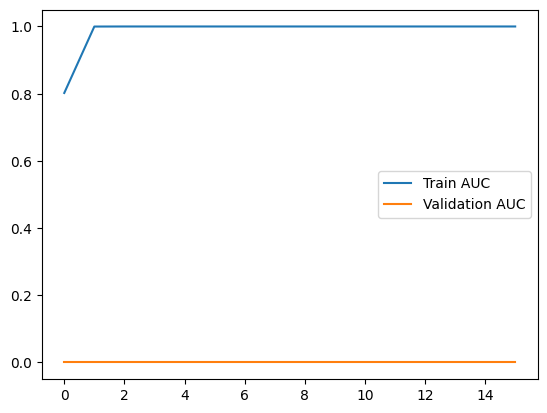

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Callback para salvar o melhor modelo
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Nome do arquivo
    monitor='val_auc',         # Métrica a ser monitorada
    save_best_only=True,       # Salvar apenas o melhor modelo
    mode='max',                # Maximizar a métrica (AUC)
    verbose=1                  # Mostrar mensagens
)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,
    mode='max',
    restore_best_weights=True
)

# Callbacks combinados
callbacks = [early_stop, checkpoint]

# Treinamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,  # Agora inclui o ModelCheckpoint
    verbose=1
)

# Plot de métricas
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.show()

9 . Carregando o modelo

In [44]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

# 1. Carregar o modelo salvo
folder = "/content/drive/MyDrive/Colab Notebooks/vibration_motor_dataset/"
best_model = load_model('best_model.h5')


data_tests = ['healthy.csv', '0.7inner-200watt.csv', '0.9inner-200watt.csv', '1.1inner-200watt.csv', '1.3inner-200watt.csv', '1.5inner-200watt.csv', '1.7inner-200watt.csv']

for data_test in data_tests:
  # 2. Carregar os dados de healthy.csv
  # motor_data = pd.read_csv('healthy.csv', skipinitialspace=True)
  motor_data = pd.read_csv(folder + data_test, skipinitialspace=True)

  # 3. Padronizar nomes das colunas (se necessário)
  motor_data.columns = motor_data.columns.str.strip().str.replace('-', '').str.lower()

  # 4. Aplicar a mesma engenharia de features usada no treinamento
  def calculate_phase_features(df):
      df['current_avg'] = df[['currenta', 'currentb', 'currentc']].mean(axis=1)
      df['imbalance'] = df[['currenta', 'currentb', 'currentc']].std(axis=1)
      df['max_phase'] = df[['currenta', 'currentb', 'currentc']].max(axis=1)
      df['min_phase'] = df[['currenta', 'currentb', 'currentc']].min(axis=1)
      df['thd'] = (df[['currenta', 'currentb', 'currentc']].sub(df['current_avg'], axis=0)**2).mean(axis=1)**0.5 / df['current_avg']
      return df

  motor_data = calculate_phase_features(motor_data)

  # 5. Criar as janelas temporais (mesmo WINDOW_SIZE e STEP_SIZE usados no treinamento)
  WINDOW_SIZE = 60  # Exemplo: 60 amostras por janela
  STEP_SIZE = 30     # Exemplo: janela deslizante com 50% de sobreposição

  def create_sequences(df, window_size, step):
      sequences = []
      for i in range(0, len(df) - window_size + 1, step):
          window = df.iloc[i:i+window_size]
          seq_data = window[['currenta', 'currentb', 'currentc',
                          'current_avg', 'imbalance', 'max_phase',
                          'min_phase', 'thd']].values
          sequences.append(seq_data)
      return np.array(sequences)

  X_motor = create_sequences(motor_data, WINDOW_SIZE, STEP_SIZE)

  # 6. Avaliar o modelo com os dados de healthy.csv
  # Como são dados saudáveis, esperamos previsões próximas de 0
  predictions = best_model.predict(X_motor)
  mean_prediction = np.mean(predictions)
  std_prediction = np.std(predictions)

  print(f"Resultados para %s:"%data_test)
  print(f"Média das previsões: {mean_prediction:.4f}")
  print(f"Desvio padrão das previsões: {std_prediction:.4f}")

  # 7. Verificar anomalias (opcional)
  threshold = 0.5  # Defina um limiar para detecção de anomalias
  anomalies = np.sum(predictions > threshold)
  print(f"Número de janelas classificadas como anomalias: {anomalies} ({(anomalies/len(predictions))*100:.2f}%)\n\n")

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Resultados para healthy.csv:
Média das previsões: 0.0355
Desvio padrão das previsões: 0.0144
Número de janelas classificadas como anomalias: 0 (0.00%)


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Resultados para 0.7inner-200watt.csv:
Média das previsões: 0.9895
Desvio padrão das previsões: 0.0040
Número de janelas classificadas como anomalias: 4177 (100.00%)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Resultados para 0.9inner-200watt.csv:
Média das previsões: 0.9910
Desvio padrão das previsões: 0.0029
Número de janelas classificadas como anomalias: 4573 (100.00%)


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Resultados para 1.1inner-200watt.csv:
Média das previsões: 0.9903
Desvio padrão das previsões: 0.0033
Número de janelas classificadas como anomalias: 4575 (100.00%)


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Resultados para 1.3inner-200watt.csv:
Média das previsões: 0.9912
Desvio padrão das previsões: 0.0030
Número de janelas classificadas como an